In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/threads-review-app-from-google-playstore-indonesia/Threads_reviewapp.xlsx


# **Import**

In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

# **1. Data Import & EDA**

In [3]:
df = pd.read_excel('/kaggle/input/threads-review-app-from-google-playstore-indonesia/Threads_reviewapp.xlsx')

In [4]:
df.shape

(1000, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   userName            1000 non-null   object        
 1   score               1000 non-null   int64         
 2   at                  1000 non-null   datetime64[ns]
 3   content             1000 non-null   object        
 4   translated_content  1000 non-null   object        
 5   sentiment           1000 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 47.0+ KB


In [6]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
score,1000.0,3.406,1.0,2.0,4.0,5.0,5.0,1.543226
at,1000,2023-11-13 17:40:54.780999936,2023-07-05 23:06:55,2023-07-07 13:30:36,2023-07-18 11:50:27,2024-05-02 18:52:54,2024-07-17 13:23:53,NaN


## **Missing Value Check**

In [7]:
df.isnull().sum()

userName              0
score                 0
at                    0
content               0
translated_content    0
sentiment             0
dtype: int64

## **Duplicated value check**

In [8]:
df.duplicated().sum()

0

# **2. Data Transfrom**

In [9]:
df.drop(columns=['at','content'], inplace=True)

In [10]:
df = df.rename(columns = {'translated_content': 'content'})

## **Data Check**

In [11]:
df.head()

,userName,score,content,sentiment
0,Rahma Lusiana,3,- The duration of the voice recording is exten...,positive
1,EBH Gomone,5,"Always stay connected, synchronized in my fami...",positive
2,Dwi Andriani,5,"Alhamdulillah, I'm happy to be able to join th...",positive
3,Alex Penyiar Oficial,5,Every human being who has an artistic soul has...,positive
4,Agustinur M.H Saputri,5,Hello meta admin. So far the threads applicati...,positive


# **3. Data Visualization**

## **Historam**

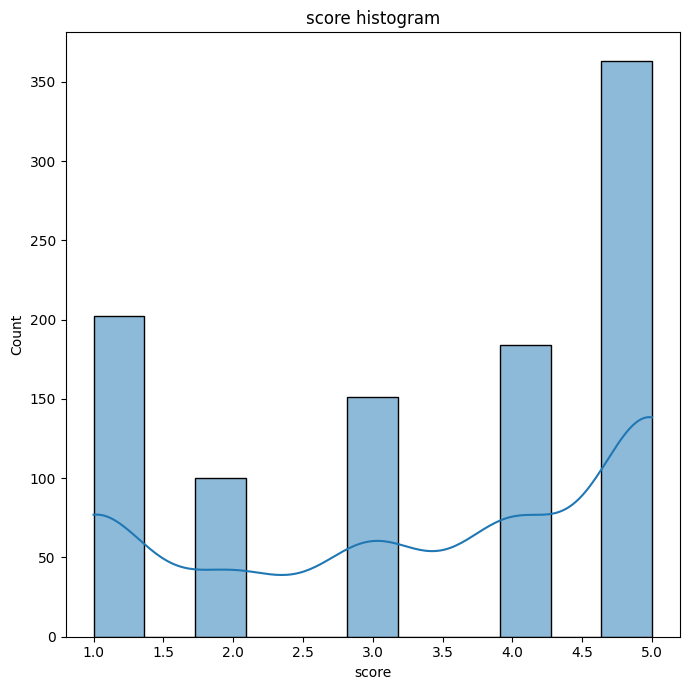

In [12]:
plt.subplots(figsize=(7, 7))
sns.histplot(df, x= 'score' ,kde = True)
plt.title('score histogram')
plt.tight_layout()
plt.show() 

## **Countplot**

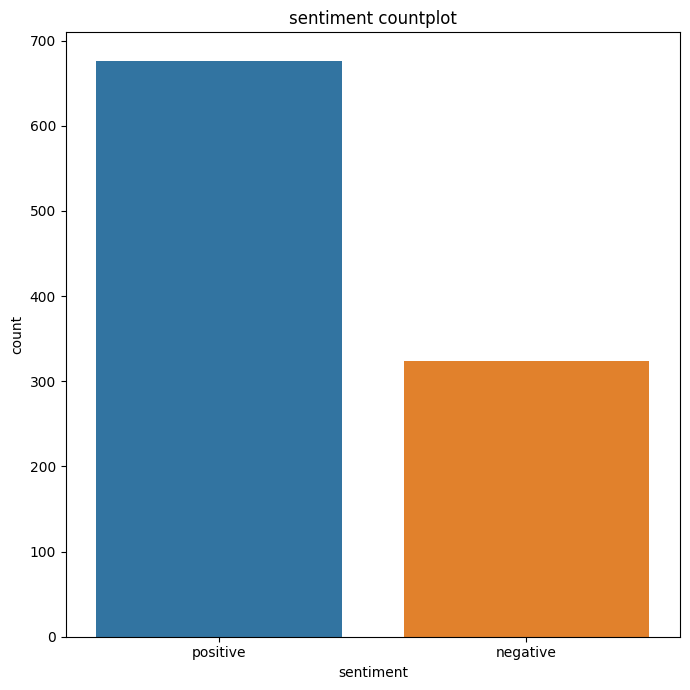

In [13]:
plt.subplots(figsize=(7, 7))
sns.countplot(df, x= 'sentiment' )
plt.title('sentiment countplot')
plt.tight_layout()
plt.show() 

## **Text Length Distribution**

In [14]:
df['content'] = df['content'].fillna('')

df['text_length'] = df['content'].apply(lambda x: len(str(x).split()))
fig = px.histogram(df, x='text_length', title='Text Length Distribution')
fig.show()

# **4.Modeling**

In [15]:
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## **Data Preprocessing**

In [16]:
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    
    return text

df['cleaned_content'] = df['content'].apply(lambda x: preprocess_text(x))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Data Augmentation**

In [17]:
def augment_text(text):
    try:
        blob = TextBlob(text)
        translated = blob.translate(to='fr').translate(to='en')
        return str(translated)
    except Exception as e:
        return text

df['augmented_content'] = df['content'].apply(augment_text)
augmented_df = df[['content', 'sentiment']].copy()
augmented_df['content'] = df['augmented_content']
df = pd.concat([df, augmented_df])

In [18]:
df['cleaned_content'] = df['content'].apply(lambda x: preprocess_text(x))

In [19]:
df['cleaned_content'] = df['cleaned_content'].fillna('')

In [20]:
df['sentiment'] = df['sentiment'].map({'negative' : '0' , 'positive' : '1'})

## **Split Data**

In [21]:
X = df['cleaned_content']
y = df['sentiment']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
vectorizer = TfidfVectorizer(max_features=5000)  
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# **Logistic Regression**

In [24]:
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [25]:
y_pred = model.predict(X_test_tfidf)

In [26]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print(f'Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.54      0.67       133
           1       0.81      0.96      0.88       267

    accuracy                           0.82       400
   macro avg       0.84      0.75      0.77       400
weighted avg       0.83      0.82      0.81       400



In [27]:
cm = confusion_matrix(y_test, y_pred)

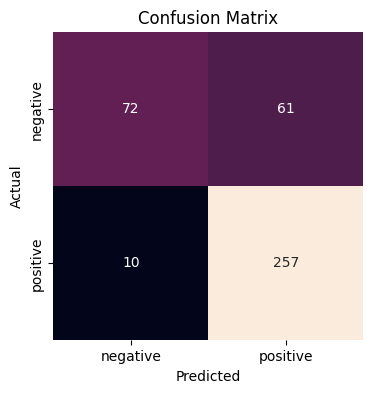

In [40]:
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)

plt.xticks(np.arange(0.5, 2), labels=['negative', 'positive'])
plt.yticks(np.arange(0.5, 2), labels=['negative', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Thankyou. Please leave your advice in the comments**